In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir(r"C:\Users\kalpe\Dropbox\PC\Downloads")
df_forecast = pd.read_excel("UV7689-XLS-ENG (1).xlsx",sheet_name='Exhibit 1')
df_timings = pd.read_excel("UV7693-XLS-ENG (1).xlsx",sheet_name='Exhibit 2')

In [2]:
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

<ipython-input-2-97b20fadfe4e>:3: UserWarning: DelftStack
  warnings.warn('DelftStack')


In [3]:
df_forecast.columns = df_forecast.iloc[3,:]
df_forecast = df_forecast.iloc[4:,:]

df_timings.columns = df_timings.iloc[3,:]
df_timings = df_timings.iloc[4:,:]

df_timings.set_index(df_timings.iloc[:,0],inplace=True)
df_timings = df_timings.iloc[:,1:]

df_forecast["Average Volume/Trip"] = df_forecast["Average Volume, dollars"]/df_forecast["Average Number of Trips/month"]

def rounding(x):
    return(round(x))

df_forecast["Average Volume/Trip"] = df_forecast["Average Volume/Trip"].apply(rounding)

In [4]:
tri_upper_diag = np.triu(df_timings, k=0)
tri_lower_diag = np.tril(df_timings, k=0)

In [5]:
One_way_timings = tri_upper_diag.T+tri_upper_diag
Second_way_timings = tri_lower_diag.T + tri_lower_diag

Trip_times = One_way_timings+Second_way_timings

df_trip_timings = pd.DataFrame(Trip_times,columns=df_timings.columns,index = df_timings.index)

In [7]:
# Tem = pd.DataFrame(Trip_times_lower,columns=df_timings.columns,index = df_timings.index)
T = df_trip_timings[list(df_forecast.sort_values(by=['Average Time Required, days','Average Volume, dollars'],ascending= False).iloc[0:3,:]['PostalCode'])]
T['Min_travel_time'] = T.apply(lambda x: min(x),1)
T = T[T['Min_travel_time'] != 0]
T = T.sort_values(by = ['Min_travel_time'])
T.drop(['Min_travel_time'],axis =1,inplace=True)

<ipython-input-7-a50069fd87f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T['Min_travel_time'] = T.apply(lambda x: min(x),1)


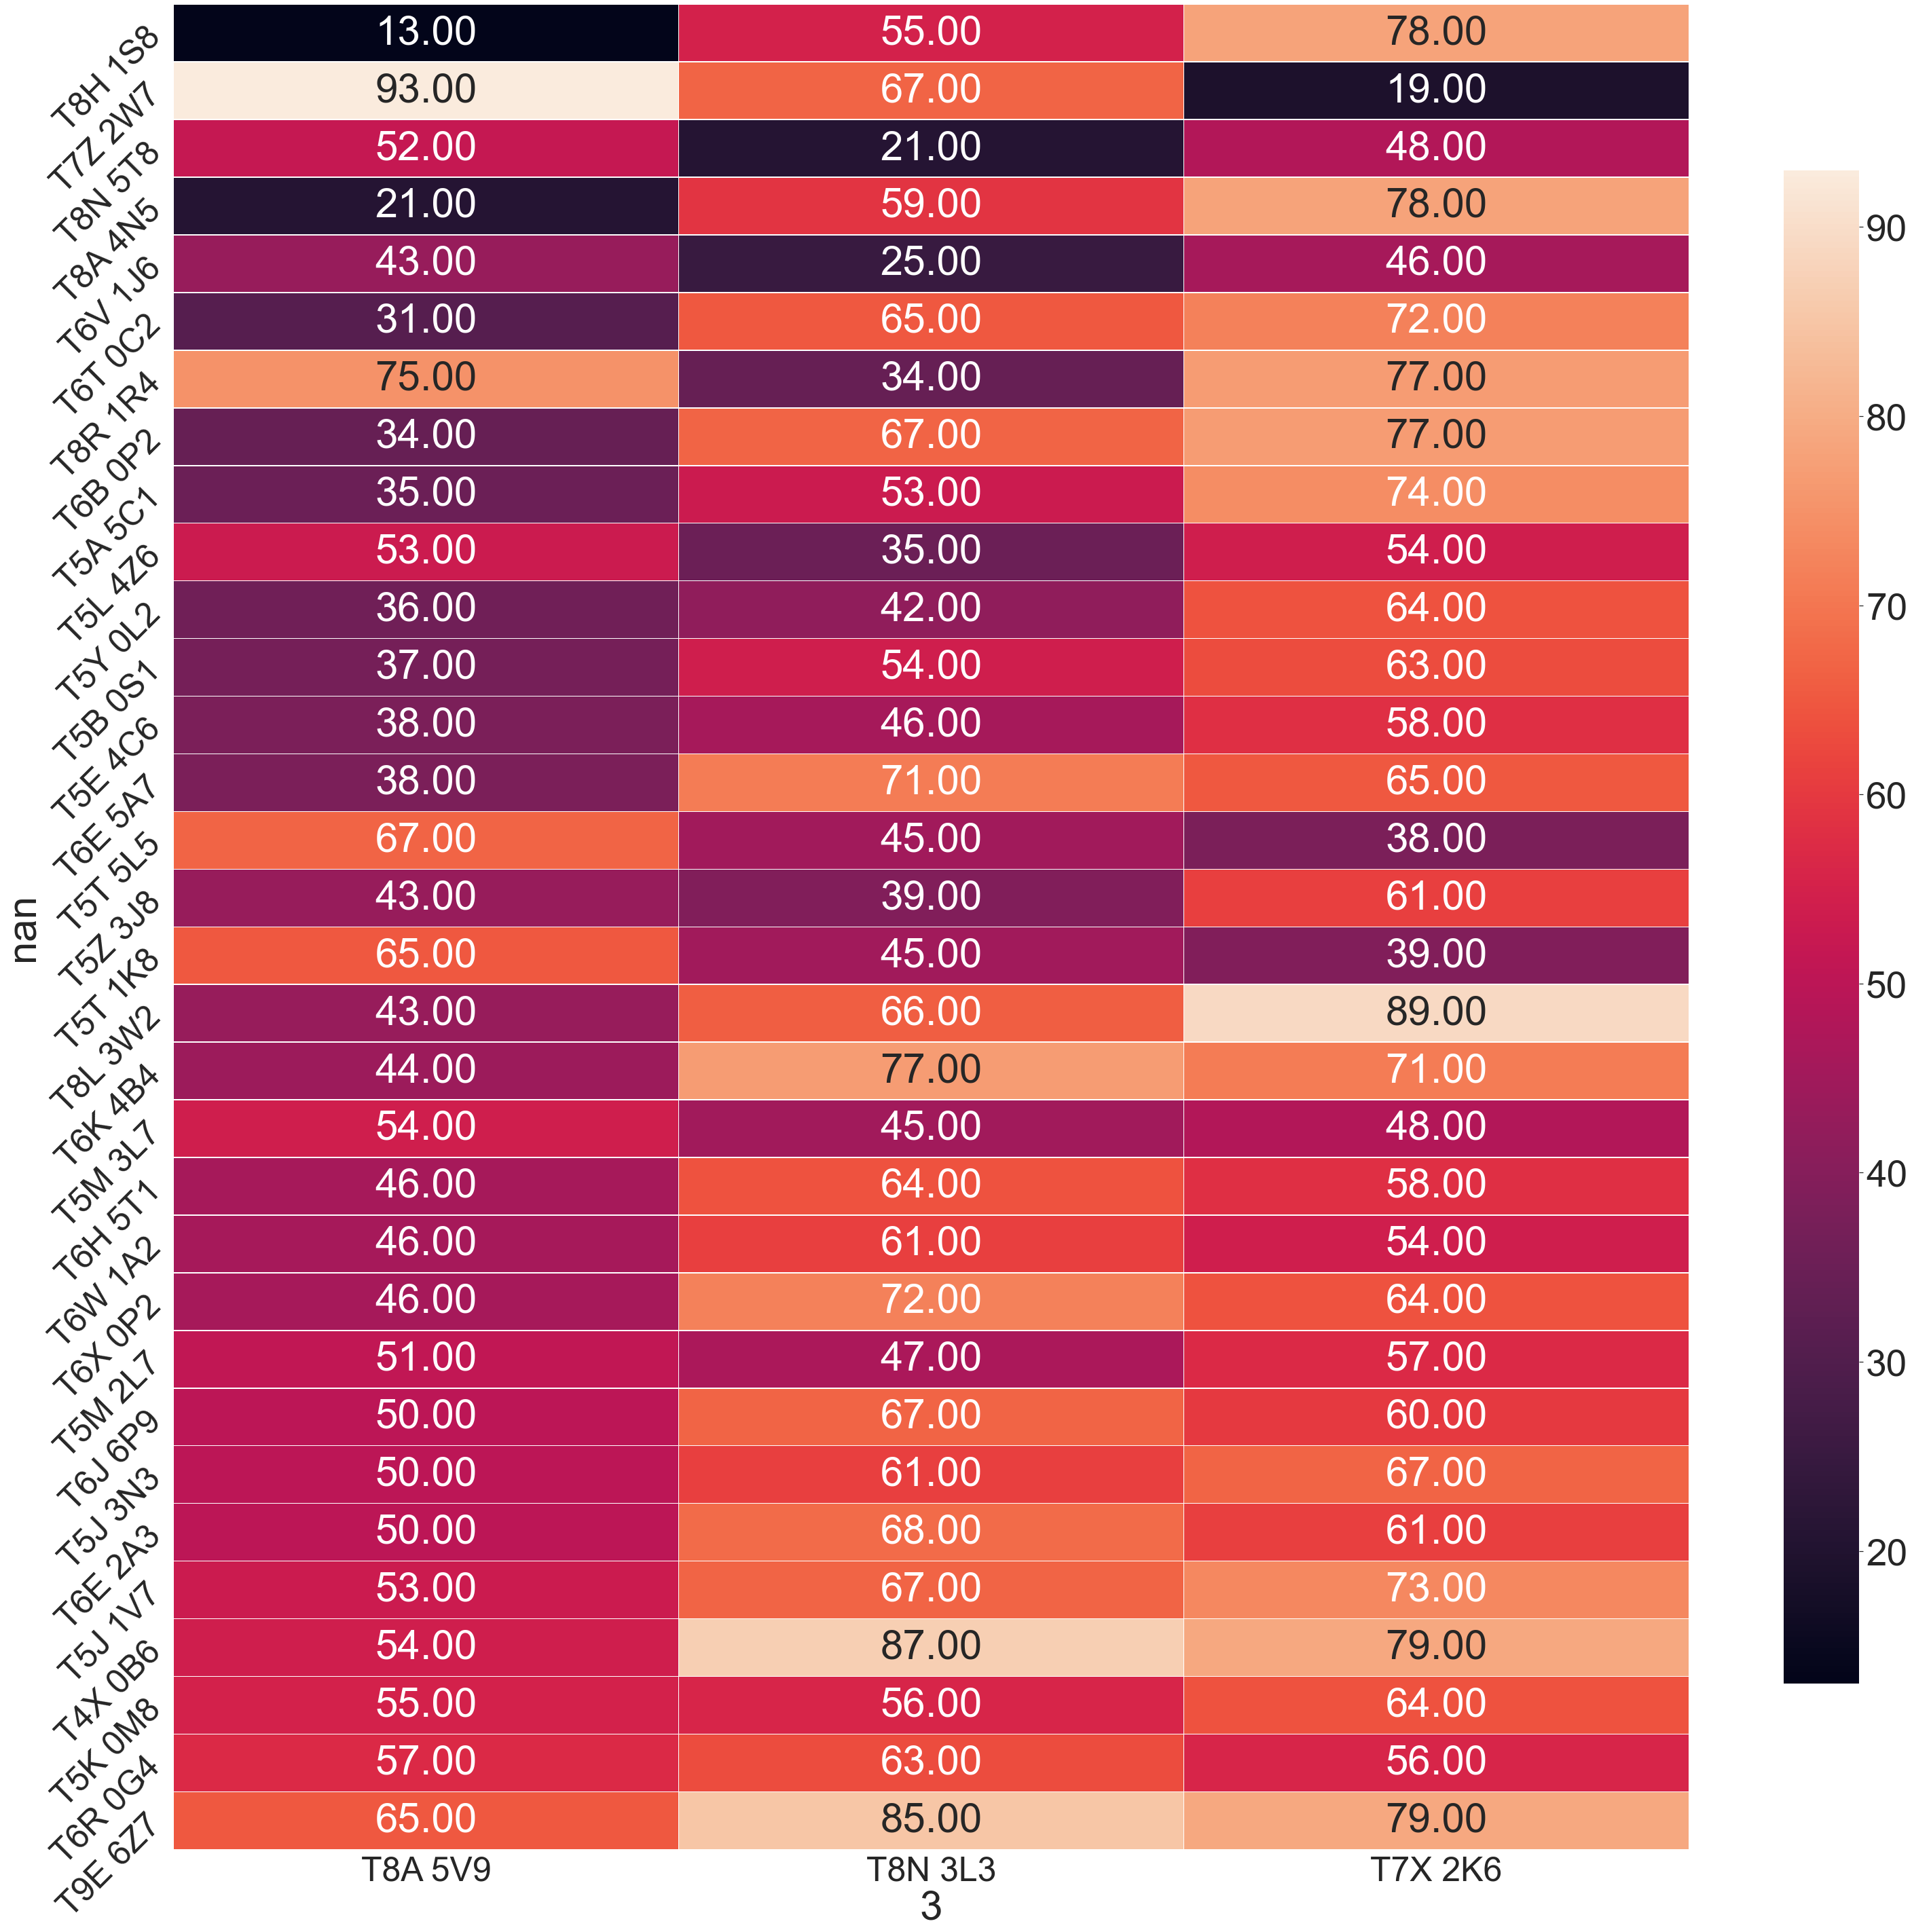

In [8]:
Trip_times_lower = np.tril(Trip_times, k=0)
plt.figure(figsize=(50 , 50))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.set(font_scale= 5)

res = sns.heatmap(T.fillna(0),annot=True, linewidths=.5,fmt='.2f', cbar_kws={"shrink": .82})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 50)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 50,rotation = 45)
plt.show()

In [9]:
df_timings = df_timings.astype('int64')
df_trip_timings = df_trip_timings.astype('int64')

In [55]:
class Profit():
    
    def __init__(self,df_timings,df_forecast,Number_of_PBA=4,skew = 0):
        self.df_timings = df_timings
        self.df_forecast = df_forecast
        self.Number_of_PBA = Number_of_PBA
        self.skew = skew
        
    def get_branches(self):
        self.chosen_branches = self.df_forecast.sort_values(by=['Average Time Required, days','Average Volume, dollars'],ascending= False).iloc[self.skew:self.Number_of_PBA+self.skew,:].sample(self.Number_of_PBA)
        Main_branch_list = list(self.chosen_branches['PostalCode'])
        Main_dict = dict([(value, key) for key, value in dict(enumerate(Main_branch_list)).items()])
        Main_branches = []
        for i in range(self.Number_of_PBA):
            Main_branch = list(self.chosen_branches.iloc[i,:]) + [list(self.chosen_branches.iloc[i,:])[1]] + [0,0] + [list(self.chosen_branches.iloc[i,:])[3]]
            columns = list(df_forecast.columns) + ['Main_Branch', 'Timing_to_travel','Total_Time_spend_In trip', 'Total_Time_Required']
            df = pd.DataFrame([Main_branch],columns=columns)
            df['Average Number of Trips/month'] = 0
            Main_branches.append(df)
        travel_times = self.df_timings[Main_branch_list]
        travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
        travel_times = travel_times[travel_times['Min_travel_time'] != 0]
        travel_times = travel_times.sort_values(by = ['Min_travel_time'])
        travel_times.drop(['Min_travel_time'],axis = 1,inplace = True)
        travel_times['Closest_Mainbranch'] = travel_times.idxmin(axis = 'columns')
        travel_times['Closest_Mainbranch'] = travel_times['Closest_Mainbranch'].replace(Main_dict)
#         print(travel_times)
        self.df = pd.DataFrame([])
        i =1
        while True:
            for index, row in travel_times.iterrows():
                To_update = Main_branches[list(row)[-1]]
                sub_branch_details = list(df_forecast[df_forecast['PostalCode']== index].iloc[0,:]) # Sub-branch-details
                main_branch_name = Main_branch_list[list(row)[-1]]
                Time_spend_onetravel = list(row)[list(row)[-1]]
                Time_spend_intrip = round(list(row)[list(row)[-1]]*sub_branch_details[4]/(24*60),3)
                Total_Time_required = round(sub_branch_details[3] + Time_spend_intrip,3)
                sub_branch_details = sub_branch_details + [main_branch_name,Time_spend_onetravel,Time_spend_intrip,Total_Time_required]
                To_update = To_update.append(pd.Series(sub_branch_details,index=To_update.columns),ignore_index=True)
                if ((To_update['Total_Time_Required'].sum())*24) > (17*8):
                    break
                elif ((To_update['Average Number of Trips/month'].sum())/17) > 1.6:
                    break
                else:
                    Main_branches[list(row)[-1]] = To_update
                    travel_times.drop(index,inplace=True)


            if self.df.empty:
                try:
                    self.df = Main_branches.pop(travel_times.iloc[0,:][-1])
                except:
                    self.df = Main_branches.pop()
                    for branch in Main_branches:
                        self.df = pd.concat([self.df,branch])
                    
            else:
                try:
                    self.df = pd.concat([self.df,Main_branches.pop(travel_times.iloc[0,:][-1])])
                except:
                    for branch in Main_branches:
                        self.df = pd.concat([self.df,branch])
                    
            if travel_times.empty:
                return(self.df)
            
            travel_times.drop([Main_branch_list[travel_times.iloc[0,:][-1]]],axis =1, inplace =True)
            Main_branch_list.pop(travel_times.iloc[0,:][-1])
            Main_dict = dict([(value, key) for key, value in dict(enumerate(Main_branch_list)).items()])
            travel_times.drop(['Closest_Mainbranch'],axis=1,inplace =True)
            
            if travel_times.empty:
                return(self.df)
            else:
                travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
                travel_times = travel_times.sort_values(by = ['Min_travel_time'])
                travel_times.drop(['Min_travel_time'],axis = 1,inplace = True)
                travel_times['Closest_Mainbranch'] = travel_times.idxmin(axis = 'columns')
                travel_times['Closest_Mainbranch'] = travel_times['Closest_Mainbranch'].replace(Main_dict)
                
    def get_metrics(self):
        Expected_Profit = (self.df.groupby('Main_Branch')['Average Volume, dollars'].sum()).sum() - p.Number_of_PBA*7000
        Total_Branches = (self.df.groupby('Main_Branch')['PostalCode'].count()).sum()
        Total_Time_Required = (self.df.groupby('Main_Branch')['Total_Time_Required'].sum()).sum()
        return(Expected_Profit,Total_Branches,Total_Time_Required)

In [56]:
p = Profit(df_trip_timings,df_forecast,Number_of_PBA=4)
DF = p.get_branches()
p.get_metrics()

<ipython-input-55-9170b4ae155c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)


(20042, 4, 24.021)

In [54]:
p.chosen_branches

3,Branch ID,PostalCode,"Average Volume, dollars","Average Time Required, days",Average Number of Trips/month,Average Volume/Trip
15,12,T5T 5L5,10563,5.2815,20,528
32,29,T8A 5V9,12751,6.3755,24,531
35,32,T8N 3L3,12695,6.3475,24,529
29,26,T7X 2K6,12033,6.0165,23,523


In [299]:
DF.to_csv('Best Branches.csv')

In [10]:
class Profit():
    
    def __init__(self,df_timings,df_forecast,Number_of_PBA=4,skew = 0):
        self.df_timings = df_timings
        self.df_forecast = df_forecast
        self.Number_of_PBA = Number_of_PBA
        self.skew = skew
        
    def get_branches(self):
        self.chosen_branches = self.df_forecast.sort_values(by=['Average Time Required, days','Average Volume, dollars'],ascending= False).iloc[self.skew:,:].sample(self.Number_of_PBA)
        Main_branch_list = list(self.chosen_branches['PostalCode'])
        Main_dict = dict([(value, key) for key, value in dict(enumerate(Main_branch_list)).items()])
        Main_branches = []
        for i in range(self.Number_of_PBA):
            Main_branch = list(self.chosen_branches.iloc[i,:]) + [list(self.chosen_branches.iloc[i,:])[1]] + [0,0] + [list(self.chosen_branches.iloc[i,:])[3]]
            columns = list(df_forecast.columns) + ['Main_Branch', 'Timing_to_travel','Total_Time_spend_In trip', 'Total_Time_Required']
            df = pd.DataFrame([Main_branch],columns=columns)
            df['Average Number of Trips/month'] = 0
            Main_branches.append(df)
        travel_times = self.df_timings[Main_branch_list]
        travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
        travel_times = travel_times[travel_times['Min_travel_time'] != 0]
        travel_times = travel_times.sort_values(by = ['Min_travel_time'])
        travel_times.drop(['Min_travel_time'],axis = 1,inplace = True)
        travel_times['Closest_Mainbranch'] = travel_times.idxmin(axis = 'columns')
        travel_times['Closest_Mainbranch'] = travel_times['Closest_Mainbranch'].replace(Main_dict)
        self.df = pd.DataFrame([])
        i =1
        while True:
            for index, row in travel_times.iterrows():
                To_update = Main_branches[list(row)[-1]]
                sub_branch_details = list(df_forecast[df_forecast['PostalCode']== index].iloc[0,:]) # Sub-branch-details
                main_branch_name = Main_branch_list[list(row)[-1]]
                Time_spend_onetravel = list(row)[list(row)[-1]]
                Time_spend_intrip = round(list(row)[list(row)[-1]]*sub_branch_details[4]/(8*60),3)
                Total_Time_required = round(sub_branch_details[3] + Time_spend_intrip,3)
                sub_branch_details = sub_branch_details + [main_branch_name,Time_spend_onetravel,Time_spend_intrip,Total_Time_required]
                To_update = To_update.append(pd.Series(sub_branch_details,index=To_update.columns),ignore_index=True)
                if ((To_update['Total_Time_Required'].sum())) > 17:
                    break
#                 elif ((To_update['Average Number of Trips/month'].sum())/17) > 1.6:
#                     break
                else:
                    Main_branches[list(row)[-1]] = To_update
                    travel_times.drop(index,inplace=True)


            if self.df.empty:
                try:
                    self.df = Main_branches.pop(travel_times.iloc[0,:][-1])
                except:
                    self.df = Main_branches.pop()
                    for branch in Main_branches:
                        self.df = pd.concat([self.df,branch])
                    
            else:
                try:
                    self.df = pd.concat([self.df,Main_branches.pop(travel_times.iloc[0,:][-1])])
                except:
                    for branch in Main_branches:
                        self.df = pd.concat([self.df,branch])
                    
            if travel_times.empty:
                return(self.df)
            
            travel_times.drop([Main_branch_list[travel_times.iloc[0,:][-1]]],axis =1, inplace =True)
            Main_branch_list.pop(travel_times.iloc[0,:][-1])
            Main_dict = dict([(value, key) for key, value in dict(enumerate(Main_branch_list)).items()])
            travel_times.drop(['Closest_Mainbranch'],axis=1,inplace =True)
            
            if travel_times.empty:
                return(self.df)
            else:
                travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
                travel_times = travel_times.sort_values(by = ['Min_travel_time'])
                travel_times.drop(['Min_travel_time'],axis = 1,inplace = True)
                travel_times['Closest_Mainbranch'] = travel_times.idxmin(axis = 'columns')
                travel_times['Closest_Mainbranch'] = travel_times['Closest_Mainbranch'].replace(Main_dict)
                
    def get_metrics(self):
        Revenue = (self.df.groupby('Main_Branch')['Average Volume, dollars'].sum()).sum()
        Expected_Profit = (self.df.groupby('Main_Branch')['Average Volume, dollars'].sum()).sum() - p.Number_of_PBA*7000
        Total_Branches = (self.df.groupby('Main_Branch')['PostalCode'].count()).sum()
        Total_Time_Required = (self.df.groupby('Main_Branch')['Total_Time_Required'].sum()).sum()
        return(Revenue,Expected_Profit,Total_Branches,Total_Time_Required)

In [108]:
import random
df = []
i = 0
best_profit = 0
Df_best = 0
while i < 200:
    skew = 0
    p = Profit(df_trip_timings,df_forecast,Number_of_PBA=3,skew = skew)
    DF = p.get_branches()
    Main_Branches = '|'.join(sorted(p.chosen_branches['PostalCode']))
    Revenue, Expected_Profit, Total_Branches, Work_time = p.get_metrics()
    if Expected_Profit > best_profit:
        Df_best = DF
        best_profit = Expected_Profit
    df.append([Main_Branches,Revenue, Expected_Profit,Total_Branches,Work_time])
    i = i+1
Main_Branches_3 = pd.DataFrame(df,columns = ['Main_Branches','Revenue','Expected_Profit','Total_Branches','Work_time'])

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [109]:
Main_Branches_3.sort_values(by=['Main_Branches']).drop_duplicates().sort_values(by = ['Expected_Profit'],ascending =False)
# Df_best_4.sort_values(by=['PostalCode'])

,Main_Branches,Revenue,Expected_Profit,Total_Branches,Work_time
104,T5K 0M8|T6J 6P9|T8A 5V9,81010,60010,26,49.9630
77,T5M 2L7|T6W 1A2|T8H 1S8,80118,59118,27,49.0965
44,T5M 2L7|T6J 6P9|T8R 1R4,78870,57870,24,50.3570
37,T6W 1A2|T7Z 2W7|T8A 5V9,78628,57628,18,47.6695
66,T5A 5C1|T6J 6P9|T6V 1J6,78306,57306,22,48.2900
...,...,...,...,...,...
152,T5J 1V7|T6K 4B4|T9E 6Z7,54605,33605,24,35.2780
87,T5A 5C1|T6E 5A7|T6H 5T1,54186,33186,22,34.2955
147,T5Z 3J8|T6T 0C2|T6V 1J6,53486,32486,20,32.5590
11,T6W 1A2|T6X 0P2|T9E 6Z7,49363,28363,16,32.1235


In [110]:
import random
df = []
i = 0
best_profit = 0
best_time = 10000
Df_best_4 = 0
while i < 200:
    skew = 0
    p = Profit(df_trip_timings,df_forecast,Number_of_PBA=4,skew = skew)
    DF = p.get_branches()
    Main_Branches = '|'.join(sorted(p.chosen_branches['PostalCode']))
    Revenue, Expected_Profit, Total_Branches, Work_time = p.get_metrics()
    if Expected_Profit > best_profit:
        if best_time > Work_time:
            Df_best_4 = DF
            best_profit = Expected_Profit
            best_time = Work_time
    df.append([Main_Branches,Revenue, Expected_Profit,Total_Branches,Work_time])
    i = i+1
Main_Branches_4 = pd.DataFrame(df,columns = ['Main_Branches','Revenue','Expected_Profit','Total_Branches','Work_time'])

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-107-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [124]:
Main_Branches_4.sort_values(by=['Main_Branches']).drop_duplicates().sort_values(by = ['Expected_Profit'],ascending =False)

,Main_Branches,Revenue,Expected_Profit,Total_Branches,Work_time
29,T5E 4C6|T6W 1A2|T8A 5V9|T8N 5T8,103965,75965,33,64.6185
178,T5T 5L5|T6E 5A7|T8H 1S8|T8R 1R4,101442,73442,31,63.9455
48,T5A 5C1|T5T 1K8|T6E 5A7|T8R 1R4,101442,73442,31,65.5145
176,T5A 5C1|T6E 5A7|T6X 0P2|T8N 3L3,101350,73350,32,63.6500
58,T6E 5A7|T6R 0G4|T7Z 2W7|T8N 3L3,101111,73111,31,63.4185
...,...,...,...,...,...
30,T5J 3N3|T5T 1K8|T6E 5A7|T6R 0G4,71080,43080,28,44.0090
52,T5J 3N3|T5K 0M8|T6K 4B4|T6X 0P2,71080,43080,28,45.4855
95,T5E 4C6|T5M 2L7|T6E 2A3|T6K 4B4,70996,42996,28,44.0805
72,T5Y 0L2|T6E 5A7|T6H 5T1|T9E 6Z7,68283,40283,26,44.3790


In [11]:
import random
df = []
i = 0
best_profit = 0
best_time = 10000
Df_best_5 = 0
while i < 1000:
    skew = random.randint(0,1)
    p = Profit(df_trip_timings,df_forecast,Number_of_PBA=5,skew = skew)
    DF = p.get_branches()
    Main_Branches = '|'.join(sorted(p.chosen_branches['PostalCode']))
    Revenue, Expected_Profit, Total_Branches, Work_time = p.get_metrics()
    if Expected_Profit == best_profit:
        if Work_time < best_time:
            Df_best_5 = DF
            best_profit = Expected_Profit
            best_time = Work_time
    elif Expected_Profit > best_profit:
            Df_best_5 = DF
            best_profit = Expected_Profit
            
    df.append([Main_Branches,Revenue, Expected_Profit,Total_Branches,Work_time])
    i = i+1
Main_Branches_5 = pd.DataFrame(df,columns = ['Main_Branches','Revenue','Expected_Profit','Total_Branches','Work_time'])

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['Min_travel_time'] = travel_times.apply(lambda x: min(x),1)
<ipython-input-10-be3c20033e60>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [150]:
(Main_Branches_5.sort_values(by=['Main_Branches']).drop_duplicates().sort_values(by = ['Expected_Profit'],ascending =False)).iloc[:50,:]

,Main_Branches,Revenue,Expected_Profit,Total_Branches,Work_time
291,T5E 4C6|T5J 3N3|T5T 1K8|T5Z 3J8|T6H 5T1,119000,84000,35,77.9965
16,T5T 1K8|T5Y 0L2|T6E 5A7|T6R 0G4|T6V 1J6,119000,84000,35,74.7290
200,T6B 0P2|T6K 4B4|T7Z 2W7|T8A 4N5|T8H 1S8,119000,84000,35,77.7465
148,T5E 4C6|T5M 2L7|T6B 0P2|T6V 1J6|T8N 5T8,119000,84000,35,78.0110
190,T4X 0B6|T6E 5A7|T6K 4B4|T7X 2K6|T8H 1S8,119000,84000,35,79.3330
228,T5B 0S1|T5J 1V7|T5Z 3J8|T6J 6P9|T7Z 2W7,119000,84000,35,77.1720
371,T4X 0B6|T5T 5L5|T6E 5A7|T7X 2K6|T8N 5T8,119000,84000,35,75.7765
28,T5M 2L7|T5Y 0L2|T6K 4B4|T6T 0C2|T7Z 2W7,119000,84000,35,74.8755
22,T5J 3N3|T5L 4Z6|T6E 2A3|T6J 6P9|T8R 1R4,119000,84000,35,78.9050
19,T5J 3N3|T5K 0M8|T6J 6P9|T6R 0G4|T6V 1J6,119000,84000,35,78.5740


In [116]:
Main_Branches_3.to_csv('3 Main Branches.csv')
Main_Branches_4.to_csv('4 Main Branches.csv')
Main_Branches_5.to_csv('5 Main Branches.csv')

In [129]:
Df_best_5.to_csv('Best Branches(5).csv')

In [147]:
(Df_best_5.groupby('Main_Branch')['Total_Time_Required'].sum()).sum()

73.28099999999999

In [148]:
(Df_best_5.groupby('Main_Branch')['Average Volume, dollars'].sum()).sum() - p.Number_of_PBA*7000

84000

In [155]:
DF_ = pd.read_csv('5 Main Branches.csv')

In [162]:
DF_[DF_['Expected_Profit'] == 84000].iloc[:,1:].to_csv('5 Main Branches.csv')